In [1]:
import pandas as pd
import pickle as pck
import matplotlib.pyplot as plt
import seaborn as sns
import ssaxgeo.MathToolBox as MathToolBox
import hdbscan
import numpy as np

In [2]:
# set input variables
#grp_frag_df_flpath = "/home/antonio/Projects/HlxCnt/BC70/grp_frag_df_clust-70.p"
grp_frag_df_flpath = "/home/ubuntu/Projects/git_stuff/SSAxgeo/grp_frag_df_clust-95.p"

save_dir = "./"
min_size = 4
# clustering parameters
min_cluster_size = 100
Pc_LIM = 0.4
## NOTES
# Export dataframe as csv on previous step

## Load dataframe

In [3]:
grp_frag_df = pck.load(open(grp_frag_df_flpath, 'rb')).drop(columns=[0,1])
## NOTES
# Do the drop of reduntant columns at before exporting dataframe

In [4]:
len(grp_frag_df)

701240

## Filtering fragments

In [5]:
print('@ Filtering fragments...')
print(f'  :: starting with {len(grp_frag_df)} fragments')
# 2.1 - Filter fragments
# 2.1.1- Remove extreme values
#print('  > removing extreme values...')
#t_max_cond = grp_frag_df['t_mean']<0.3#0.2
#t_min_cond = grp_frag_df['t_mean']>-0.3
#w_max_cond = grp_frag_df['w_mean']<0.3
#w_min_cond = grp_frag_df['w_mean']>-0.3
#grp_fdf_1 = grp_frag_df.loc[t_max_cond & t_min_cond & w_max_cond & w_min_cond]
#print('  :: ', len(grp_fdf_1), ' fragments remaining')

# filter by size
print(f'  > removing fragments less than {min_size} residues...')
min_size_cond = grp_frag_df["size"] >= min_size
grp_fdf_1 = grp_frag_df.loc[min_size_cond]
print('  :: ', len(grp_fdf_1), ' fragments remaining')

#grp_fdf_1.to_csv(save_dir+"/filtered_frags_1.csv")

#grp_fdf_2.to_csv(save_dir+"/filtered_frags_2.csv")

print('  > removing fragments with high standard deviations...')
c_std_cond = grp_fdf_1['c_std'] <= 0.07
t_std_cond = grp_fdf_1['t_std'] <= 0.01
grp_fdf_2 = grp_fdf_1.loc[c_std_cond & t_std_cond]
print('  :: ', len(grp_fdf_2), ' fragments remaining')
#grp_fdf_3.to_csv(save_dir+"/filtered_frags_3.csv")


@ Filtering fragments...
  :: starting with 701240 fragments
  > removing fragments less than 4 residues...
  ::  421920  fragments remaining
  > removing fragments with high standard deviations...
  ::  44781  fragments remaining


## Explore data

### Check size to standard deviation distribution

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 0.1)

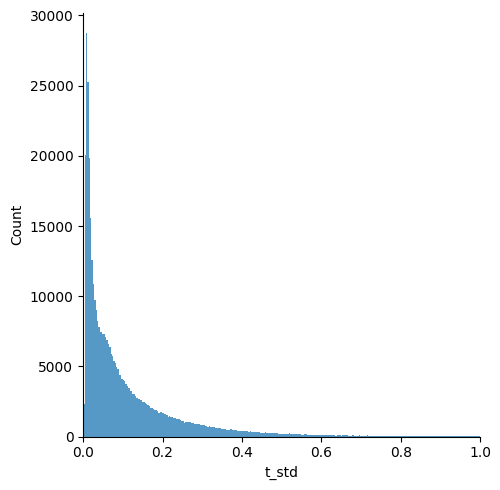

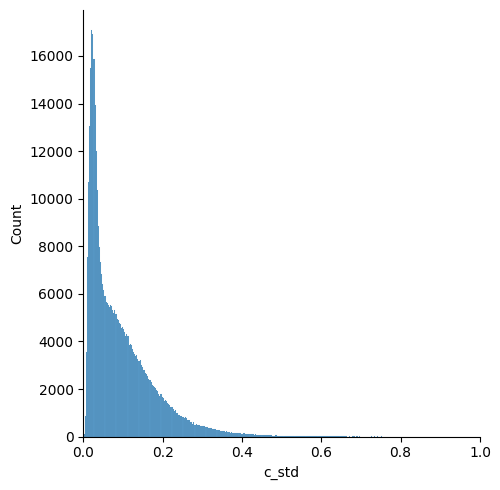

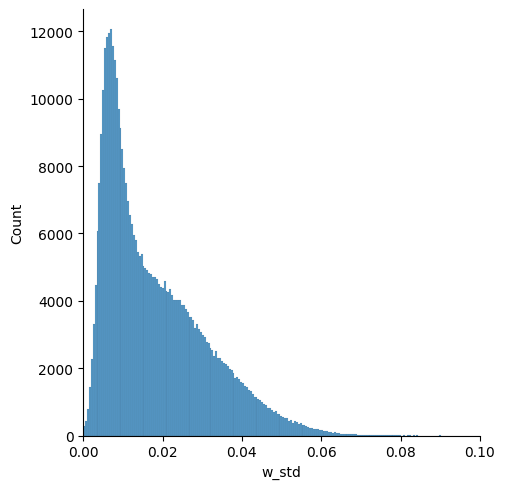

In [6]:
sns.displot(grp_fdf_1["t_std"])
plt.xlim(0,1)

sns.displot(grp_fdf_1["c_std"])
plt.xlim(0,1)

sns.displot(grp_fdf_1["w_std"])
plt.xlim(0,0.1)


(0.0, 1.0)

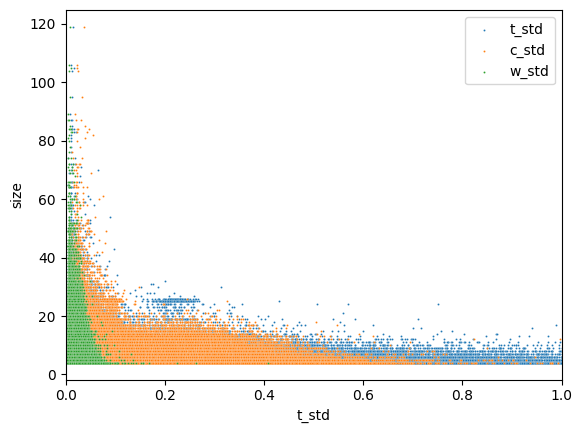

In [7]:
sns.scatterplot(data=grp_fdf_1, x="t_std", y="size", s=2, label="t_std")
sns.scatterplot(data=grp_fdf_1, x="c_std", y="size", s=2, label="c_std")
sns.scatterplot(data=grp_fdf_1, x="w_std", y="size", s=2, label="w_std")
plt.xlim(0,1)


(0.0, 0.8)

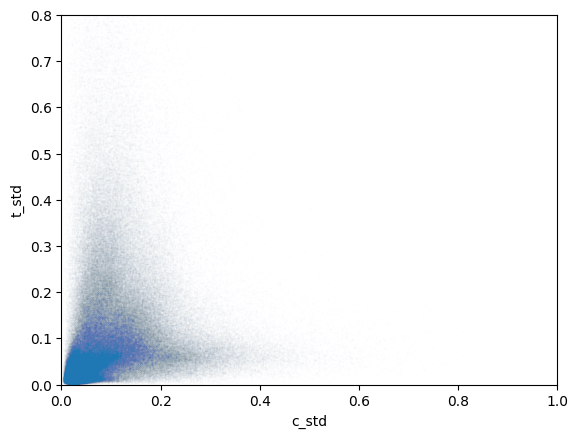

In [8]:
sns.scatterplot(data=grp_fdf_1, x="c_std", y="t_std", alpha=0.01, s=2)
#sns.scatterplot(data=grp_fdf_1, x="c_std", y="size", s=2, label="c_std")
#sns.scatterplot(data=grp_fdf_1, x="w_std", y="size", s=2, label="w_std")
plt.xlim(0,1)
plt.ylim(0, 0.8)

### FILTER BY STD

  > removing fragments with high standard deviations...
  ::  82743  fragments remaining


(-0.5, 0.5)

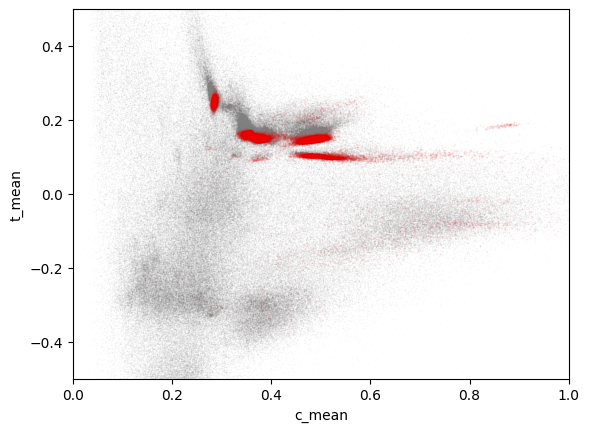

In [9]:
# test std filters
print('  > removing fragments with high standard deviations...')
#c_std_cond = grp_fdf_1['c_std'] <= 0.1
#t_std_cond = grp_fdf_1['t_std'] <= 0.1
# paper tresholds
c_std_cond = grp_fdf_1['c_std'] <= 0.55
t_std_cond = grp_fdf_1['t_std'] <= 0.015

grp_fdf_new = grp_fdf_1.loc[c_std_cond & t_std_cond]
print('  :: ', len(grp_fdf_new), ' fragments remaining')
sns.scatterplot(data=grp_fdf_1, x="c_mean", y="t_mean", s=1, alpha=0.05, c="grey")
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=2, alpha=0.05, c="red")
plt.xlim(0,1.0)
plt.ylim(-0.5,0.5)


(-0.5, 0.5)

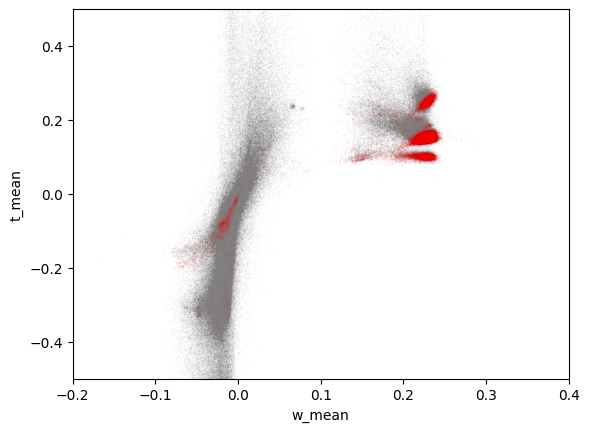

In [10]:
sns.scatterplot(data=grp_fdf_1, x="w_mean", y="t_mean", s=1, alpha=0.05, c="grey")
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=2, alpha=0.05, c="red")
plt.xlim(-0.2,0.4)
plt.ylim(-0.5,0.5)

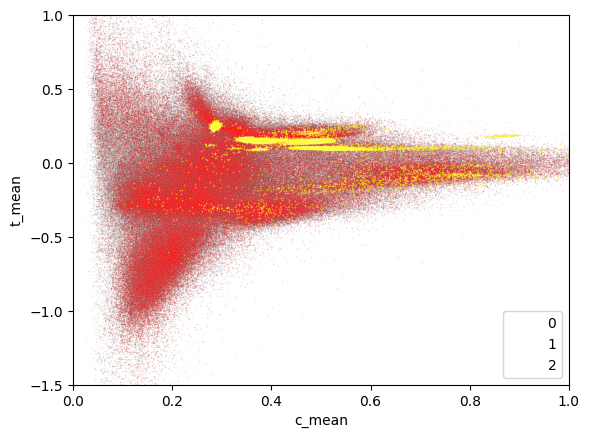

In [11]:
### Check changes due to filtering
#hist load precomputed fragments data
#filtered_frag_1 = pd.read_csv("filtered_frags_1.csv") # only extreme values were filtered
#filtered_frag_2 = pd.read_csv("filtered_frags_2.csv") # filtered by curvature and torsion standard deviations
sns.scatterplot(data=grp_frag_df, x="c_mean", y="t_mean", s=1, alpha=0.1,label="0", c="grey")
sns.scatterplot(data=grp_fdf_1, x="c_mean", y="t_mean", s=1, alpha=0.1,label="1", c="red")
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=1, alpha=0.5,label="2", c="yellow")
#sns.scatterplot(data=grp_fdf_3, x="c_mean", y="t_mean", s=2, alpha=0.5,label="3", c="blue")
plt.xlim(0,1.0)
plt.ylim(-1.5,1.0)
plt.legend()

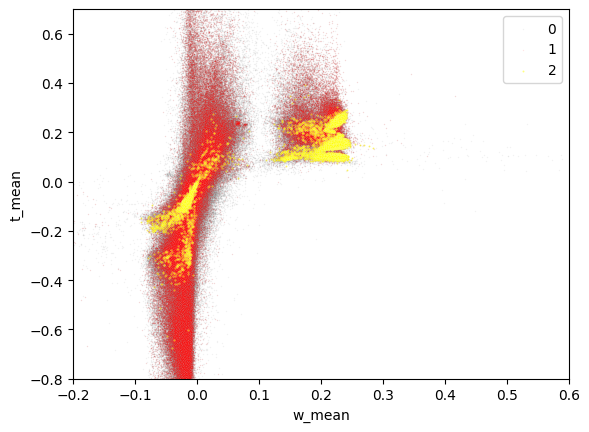

In [12]:
sns.scatterplot(data=grp_frag_df, x="w_mean", y="t_mean", s=1, alpha=0.1,label="0", c="grey")
sns.scatterplot(data=grp_fdf_1, x="w_mean", y="t_mean", s=1, alpha=0.1,label="1", c="red")
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=2, alpha=0.5,label="2", c="yellow")
plt.xlim(-0.2,0.6)
plt.ylim(-0.8,0.7)
plt.legend()

<Axes: xlabel='w_mean', ylabel='t_mean'>

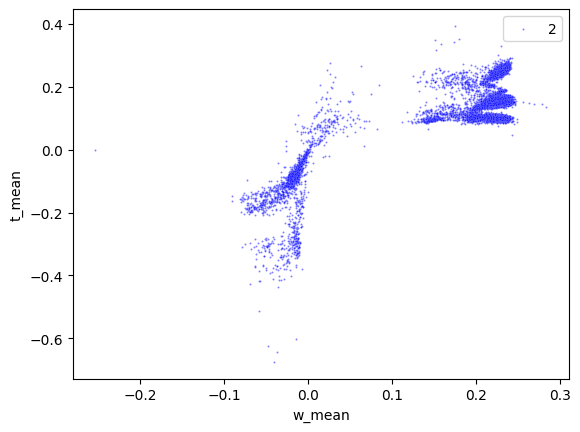

In [13]:
# final set
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=2, alpha=0.5,label="2", c="blue")

# load fragments data
#filtered_frag_1 = pd.read_csv("filtered_frags_1.csv") # only extreme values were filtered
#filtered_frag_2 = pd.read_csv("filtered_frags_2.csv") # filtered by curvature and torsion standard deviations




<Axes: xlabel='c_mean', ylabel='t_mean'>

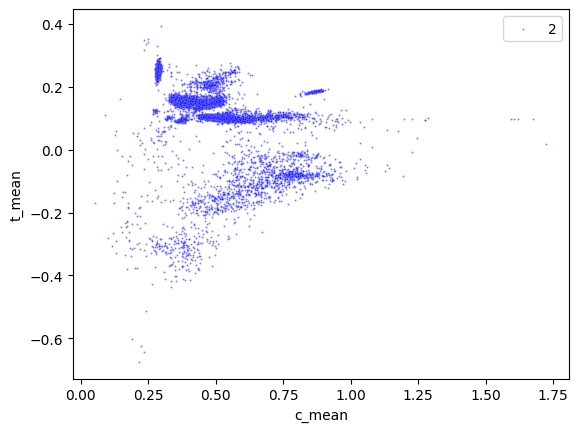

In [14]:
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=2, alpha=0.5,label="2", c="blue")


# Clustering

In [15]:
def cluster_grp_frags(frag_df, max_d=1.0, show_plot=False,
    cols = ['c_mean', 'w_mean', 't_mean'], method='kmeans', **cls_kwargs):
    '''Recluster group fragment dataframe.'''
    #TODO add sanity check
    VALID_METHODS = ['kmeans', 'hdbscan', 'hierarc']
    assert(method in VALID_METHODS), '{} not supported'.format(method)

    # get data to cluster
    #vld_frag_df = self.grp_frag_df[cols]
    vld_frag_df = frag_df[cols]

    if method == 'hierarc':
            # TODO improve kwargs handling, instead of using a default value
            #      maybe will be better to let the user have more control
            max_d = cls_kwargs.get('max_d', 1.0)
            # Calculate linkage matrix
            Z = MathToolBox.get_linkage_mtx_of(vld_frag_df)

            # get clusters assignment array
            clusters = fcluster(Z, max_d, criterion='distance')

            # generate plots
            if show_plot is True:
                MathToolBox.fancy_dendrogram(Z,
                    truncate_mode='lastp', p=12,# show only the last p merged clusters
                    leaf_rotation=90.,
                    leaf_font_size=12.,
                    show_contracted=True,
                    annotate_above=0.1,  # useful in small plots so annotations don't overlap
                    max_d=max_d)

    if method == 'kmeans':
            # clustering specific arguments
            err_msg = 'n_clusters = <int> must be provided for kmeans'
            assert('n_clusters' in cls_kwargs), err_msg

            n_clusters = cls_kwargs['n_clusters']
            random_state = cls_kwargs.get('random_state', 0)
            n_jobs= cls_kwargs.get('n_jobs', 1)

            # do the clustering
            clusters = MathToolBox.run_kmeans_at(vld_frag_df,
                        n_clusters, random_state=random_state, n_jobs=n_jobs)

    if method == 'hdbscan':
            # got clustering arguments
            min_cluster_size = cls_kwargs['min_cluster_size']
            do_soft = cls_kwargs.get('do_soft', True)
            use_distMTX = cls_kwargs.get('use_distMTX', False)
            allow_single_cluster=cls_kwargs.get('allow_single_cluster', True)

            # do the clustering
            clusterer = MathToolBox.do_hdbscan_at(vld_frag_df,
                            min_cluster_size,do_soft=do_soft,
                            use_distMTX=use_distMTX,
                            allow_single_cluster=allow_single_cluster)
            clusters = clusterer.labels_

    ### NOTE ###########################################################
    ## for the future, add clusters probabilities for soft clustering
    ####################################################################

    # add clustering results column to group fragments dataframe
    cluster_col = pd.DataFrame(clusters, columns=['grp_frag_clusters'],
                               index=vld_frag_df.index)
    final_df = pd.concat([frag_df, cluster_col], axis=1)
    if method == 'hdbscan' and do_soft == True:
            return final_df, clusterer
    else:
            return final_df


def get_core_labels(df, Pc_LIM):
    '''
    Check if a residue belongs to the 'core' of the cluster.
    The core points in a cluster are consider each an every point which the
    membership probability is greater than a specified limit (default=0.60).
    '''
    def _check_prob(row):
        Pc_max = np.array(row['membership_vec']).max()
        if Pc_max >= Pc_LIM:
            return True
        else:
            return False

    return df.apply(_check_prob, axis=1)



In [ ]:
# NOTES
# Struggling to replicate, maybe worths try the strategy bellow:
#  1 - Get dssp concordant set of fragments (SS agreed with frag definitions)
#  2 - check how it looks, if it looks reasonable
#  3 - cluster this first, then use it for soft clustering of the remaning data
#  4 - now select only the ones on 



In [16]:
grp_fdf_new[["pdbid", "chain", "ss", "ss_pp2"]].iloc[0].values#.columns

ss_array = ['E', 'E', 'E', 'E', 'E', 'P']

def count_occurrences_above_threshold(arr, threshold_percentage=75):

    unique_elements, counts = np.unique(arr, return_counts=True)
    try:
        total_elements = len(arr)
    except(TypeError):
        return None
    # Calculate the occurrence percentages
    percentages = (counts / total_elements) * 100

    # Find elements with occurrence higher than the threshold
    result = unique_elements[percentages > threshold_percentage]

    if len(result) > 0:
        assert(len(result) == 1)
        return result.tolist()[0]
    else:
        return None

grp_fdf_new["ss_major"] = grp_fdf_new["ss"].apply(count_occurrences_above_threshold, threshold_percentage=75)

/tmp/ipykernel_129012/1256243368.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grp_fdf_new["ss_major"] = grp_fdf_new["ss"].apply(count_occurrences_above_threshold, threshold_percentage=75)


(-0.5, 0.4)

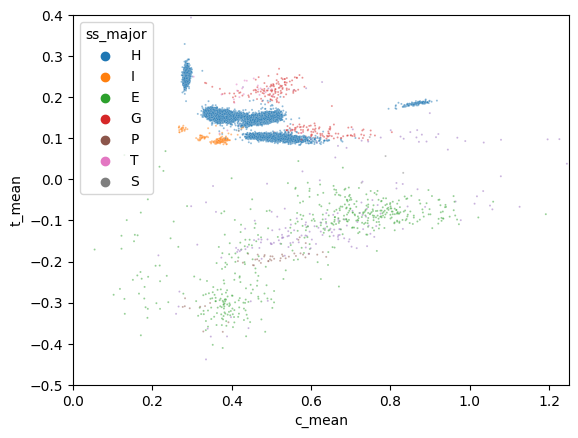

In [17]:
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")
plt.xlim(0,1.25)
plt.ylim(-0.5,0.4)

<Axes: xlabel='ws_mean', ylabel='ts_mean'>

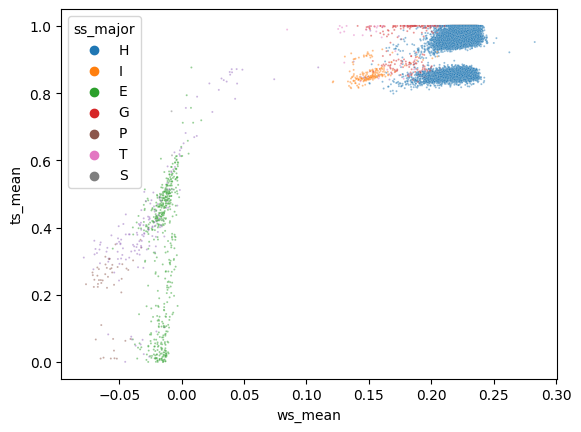

In [51]:
sns.scatterplot(data=grp_fdf_new, x="ws_mean", y="ts_mean", s=2, alpha=0.5,hue="ss_major")
#plt.xlim(0,1.25)
#plt.ylim(-0.5,0.4)

<Axes: xlabel='w_mean', ylabel='t_mean'>

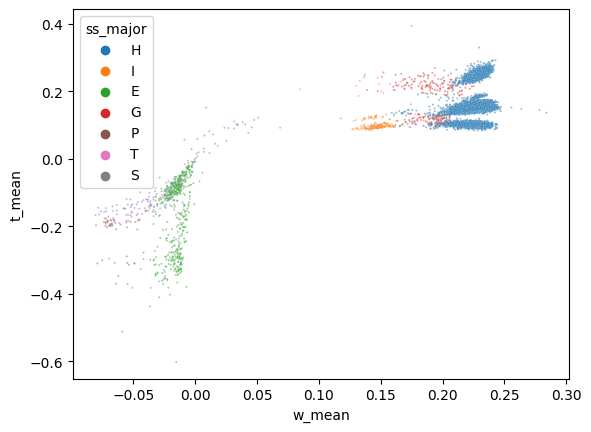

In [18]:
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")


<Axes: xlabel='c_mean', ylabel='t_mean'>

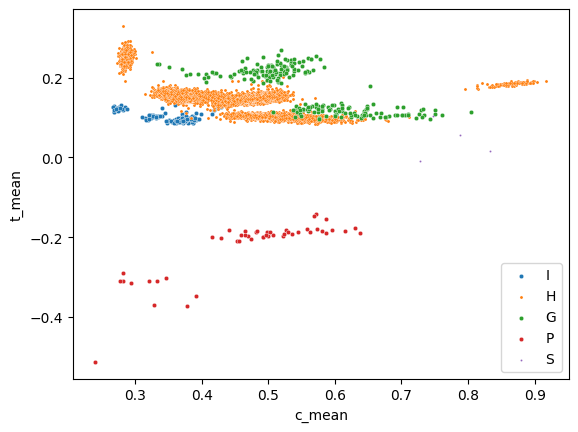

In [113]:
#sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=2, alpha=0.05,hue="ss_major")
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="I"], x="c_mean", y="t_mean", s=10, alpha=1,label="I")
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="H"], x="c_mean", y="t_mean", s=5, alpha=1,label="H")
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="G"], x="c_mean", y="t_mean", s=10, alpha=1,label="G")
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="P"], x="c_mean", y="t_mean", s=10, alpha=1,label="P")
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="S"], x="c_mean", y="t_mean", s=2, alpha=1,label="S")

#sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="H"], x="c_mean", y="t_mean", s=2, alpha=0.1,label="H")

In [111]:

grp_fdf_new.loc[(grp_fdf_new["c_mean"] >= 0.8) & (grp_fdf_new["t_mean"] >= 0)][["pdbid", "chain","res_start","res_final","size","c_mean","c_raw", "c_std","cs_raw","ss"]].iloc[2].values

array(['4bwl', 'C', 1, 5, 5, 0.8038008579634747,
       array([0.89377764, 0.89377764, 0.87193867, 0.60971198, 0.74979836]),
       0.12391647115414367,
       array([0.43674353, 0.43318633, 0.38691687, 0.36346509, 0.34611414]),
       array(['', 'G', 'G', 'G', 'G'], dtype=object)], dtype=object)

In [107]:
def _getNPmean(row):
    return np.mean(row)
grp_fdf_new["c"]

0.036429740901055226

In [47]:
grp_fdf_new.loc[(grp_fdf_new["c_mean"] >= 0.8) & (grp_fdf_new["t_mean"] >= 0)][["pdbid", "chain","res_start","res_final","size","c_mean","c_raw"]].values

array([['7vpe', 'A', 1148, ..., 11, 0.8889690939289696,
        array([0.75947664, 0.92586247, 0.87268917, 0.8861696 , 0.89078369,
               0.89157248, 0.92556216, 0.85293161, 0.87966826, 0.7839038 ,
               1.11004014])                                               ],
       ['7vpe', 'A', 1175, ..., 6, 0.8312103583790261,
        array([0.87269354, 0.80685669, 0.84279076, 0.87160324, 0.81610733,
               0.7772106 ])                                               ],
       ['4bwl', 'C', 1, ..., 5, 0.8038008579634747,
        array([0.89377764, 0.89377764, 0.87193867, 0.60971198, 0.74979836])],
       ...,
       ['5npk', 'd', 423, ..., 4, 0.9546353957186702,
        array([0.74293017, 1.21179648, 0.96658762, 0.89722731])],
       ['4coo', 'B', 51, ..., 4, 1.2449036597307441,
        array([1.59665174, 0.87644933, 1.68013873, 0.82637484])],
       ['4w7d', 'B', 5, ..., 4, 0.8223763592360086,
        array([1.05008775, 1.05008775, 0.52380604, 0.6655239 ])]],
      dtyp

<Axes: xlabel='w_mean', ylabel='t_mean'>

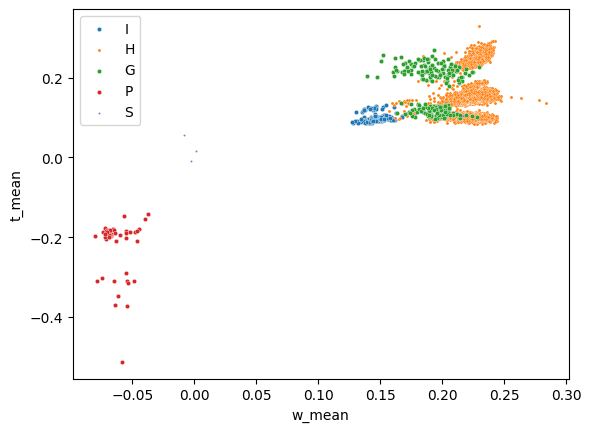

In [37]:
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="I"], x="w_mean", y="t_mean", s=10, alpha=1,label="I")
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="H"], x="w_mean", y="t_mean", s=5, alpha=1,label="H")
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="G"], x="w_mean", y="t_mean", s=10, alpha=1,label="G")
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="P"], x="w_mean", y="t_mean", s=10, alpha=1,label="P")
sns.scatterplot(data=grp_fdf_new.loc[grp_fdf_new["ss_major"]=="S"], x="w_mean", y="t_mean", s=2, alpha=1,label="S")

In [21]:
grp_fdf_new[["pdbid", "chain", "ss", "ss_pp2", "ss_major"]].loc[grp_fdf_new["ss_major"] == "I"]

,pdbid,chain,ss,ss_pp2,ss_major
507,2fsh,B,"[I, I, I, I]","[I, I, I, I]",I
3120,1khb,A,"[I, I, I, I, I, I, I]","[I, I, I, I, I, I, I]",I
4440,3cw9,B,"[I, I, I, I, I]","[I, I, I, I, I]",I
6876,2o1c,D,"[I, I, I, I, ]","[I, I, I, I, ]",I
8435,3gke,A,"[I, I, I, I]","[I, I, I, I]",I
...,...,...,...,...,...
696931,3sk3,B,"[I, I, I, I]","[I, I, I, I]",I
697555,4rlf,B,"[I, I, I, I, I, T]","[I, I, I, I, I, T]",I
699160,5g1m,B,"[I, I, I, I, I, I, I]","[I, I, I, I, I, I, I]",I
700503,6r5v,B,"[I, I, I, I, I, I, I]","[I, I, I, I, I, I, I]",I


## Alpha/Pi/3(10) canonical regions

|---------| Alpha/Pi/3(10) canonical region |---------|
@ clustering |w| > 0.1...
   > filtering 
  :: 82743 residues after filtering


(-0.8, 0.7)

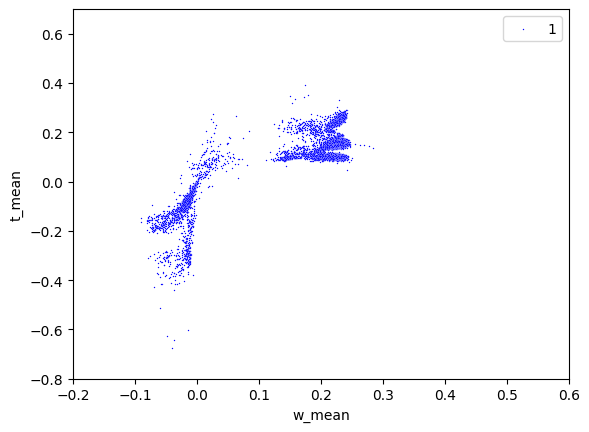

In [22]:

print('|---------| Alpha/Pi/3(10) canonical region |---------|')
# 4 - generate clusters for Pi, Alpha and 3(10)
#   Pi, Alpha and 3(10) helices residues belongs to the region of |w| > 0.1 and
# those  usually forms globular clusters. The strategy for those SSE is:
print('@ clustering |w| > 0.1...')
print('   > filtering ')
wgrtr_1 = grp_fdf_new['w_mean'] >  0.1
wgrtr_2 = grp_fdf_new['w_mean'] < -0.0
#wgrtr_2 = grp_fdf_new['w_mean'] <=  0.1

df_1 = grp_fdf_new#.loc[(wgrtr_2)]# & (wgrtr_2)]
#df_2 = grp_fdf_new.loc[wgrtr_2]

print(f'  :: {len(df_1)} residues after filtering')

#sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=1, alpha=0.1, c="blue")
sns.scatterplot(data=df_1, x="w_mean", y="t_mean", s=1, alpha=1,label="1", c="blue")
#sns.scatterplot(data=df_2, x="w_mean", y="t_mean", s=1, alpha=0.5,label="2", c="red")

plt.xlim(-0.2,0.6)
plt.ylim(-0.8,0.7)

<Axes: xlabel='c_mean', ylabel='t_mean'>

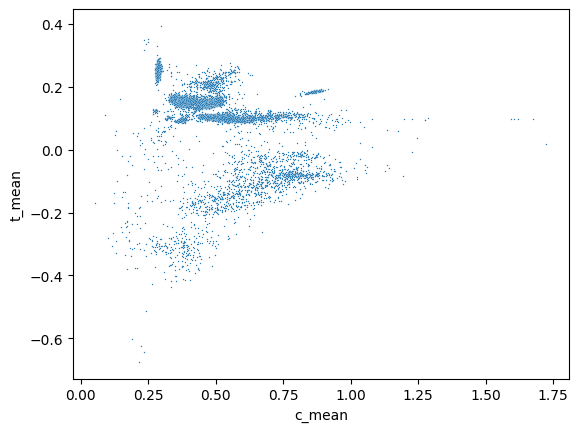

In [23]:
sns.scatterplot(data=df_1, x="c_mean", y="t_mean", s=1, alpha=1)


In [24]:

# 4.1) consider only frags with wri mean higher than 0.1 and run hdbscan
min_cluster_size = 300
print('  > running hdbscan [min_cluster_size=',min_cluster_size,']...')

df_1_2, clusterer = cluster_grp_frags(df_1, #| wgrtr_2],
                cols = ['c_mean', 'w_mean', 't_mean'], method='hdbscan',
                min_cluster_size=min_cluster_size)


# 4.2) Compute the membership vectors for the clustering assignment
print('  > computing membership vectors...')
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
df_1_2['membership_vec'] = tuple(soft_clusters)


  > running hdbscan [min_cluster_size= 300 ]...
  > computing membership vectors...


In [32]:
df_1_2[["c_raw", "c_mean"]]#.columns

,c_raw,c_mean
10,"[0.5623492324009155, 0.5502513766443505, 0.472...",0.494467
39,"[0.5323327796104458, 0.4481172715246519, 0.483...",0.492296
61,"[0.332423284230114, 0.3619674063405972, 0.3469...",0.351317
63,"[0.5463674375007666, 0.4706474813529538, 0.474...",0.476884
65,"[0.5423445534568043, 0.4726915981130633, 0.493...",0.489302
...,...,...
701229,"[0.4582747396936106, 0.4842044967386812, 0.447...",0.480936
701230,"[0.5234733468159921, 0.4524772802922492, 0.468...",0.482711
701231,"[0.504944007361243, 0.4504483677543709, 0.4947...",0.475453
701234,"[0.4929021619857284, 0.4949454110855154, 0.503...",0.487824


[ 3  4  2  1 -1  0]


<Axes: xlabel='c_mean', ylabel='t_mean'>

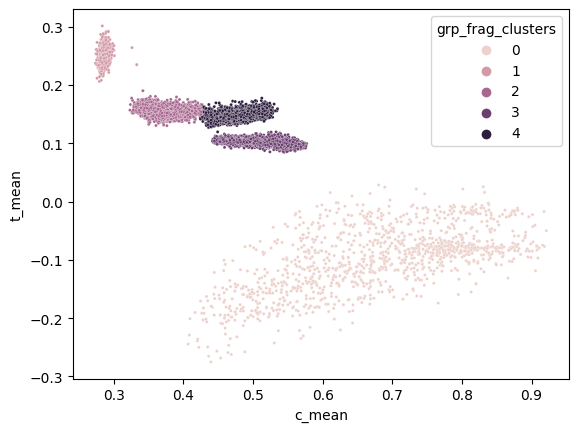

In [25]:
print(df_1_2["grp_frag_clusters"].unique())
sns.scatterplot(data=df_1_2.loc[~ (df_1_2["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2


<Axes: xlabel='w_mean', ylabel='t_mean'>

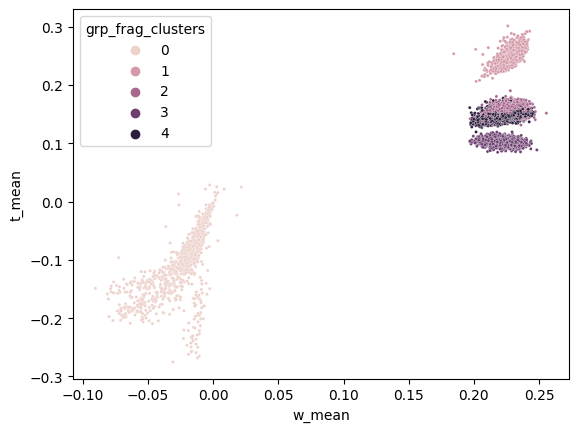

In [26]:
sns.scatterplot(data=df_1_2.loc[~ (df_1_2["grp_frag_clusters"] == -1)], x='w_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2


In [27]:
pdb_cond = df_1_2["pdbid"] == "1qk2"
chain_cond = df_1_2["chain"] == "A"
df_1_2.loc[pdb_cond & chain_cond][["pdbid", "chain","res_start","res_final","size","c_mean","t_mean","w_mean", "ss","membership_vec"]]

,pdbid,chain,res_start,res_final,size,c_mean,t_mean,w_mean,ss,membership_vec


In [28]:
size_cond = df_1_2["size"] >= 4
print(df_1_2.columns)
df_1_2.loc[(df_1_2["grp_frag_clusters"] == 4) & size_cond][["pdbid", "chain","res_start","res_final","size","c_mean","t_mean","w_mean", "ss","membership_vec"]]

Index(['res_start', 'res_final', 'kind', 'size', 'label', 'pdbid', 'chain',
       'seq', 'c_mean', 't_mean', 'w_mean', 'c_std', 't_std', 'w_std', 'c_raw',
       't_raw', 'w_raw', 'cs_raw', 'ts_raw', 'ws_raw', 'cs_mean', 'ts_mean',
       'ws_mean', 'c_std_s', 't_std_s', 'ws_std', 'phi', 'psi', 'ss', 'ss_pp2',
       'ho1_en_mean', 'ho1_A_mean', 'ho1_en_std', 'ho1_A_std', 'ho1_en_median',
       'ho1_A_median', 'ho1_en_vals', 'ho1_A_vals', 'ho2_en_mean',
       'ho2_A_mean', 'ho2_en_std', 'ho2_A_std', 'ho2_en_median', 'ho2_en_vals',
       'ho2_A_vals', 'hn1_en_mean', 'hn1_A_mean', 'hn1_en_std', 'hn1_A_std',
       'hn1_en_median', 'hn1_A_median', 'hn1_en_vals', 'hn1_A_vals',
       'hn2_en_mean', 'hn2_A_mean', 'hn2_en_std', 'hn2_A_std', 'hn2_en_median',
       'hn2_A_median', 'hn2_en_vals', 'hn2_A_vals', 'ss_major',
       'grp_frag_clusters', 'membership_vec'],
      dtype='object')


,pdbid,chain,res_start,res_final,size,c_mean,t_mean,w_mean,ss,membership_vec
39,6yiw,A,167,170,4,0.492296,0.146367,0.226917,"[H, H, H, H]","[0.048671416255618286, 0.10141358582507629, 0...."
63,3e92,A,126,142,17,0.476884,0.145349,0.226534,"[H, H, H, H, H, H, H, H, H, H, H, H, H, H, H, ...","[0.10037573741771351, 0.1955256542670377, 0.17..."
65,3e92,A,230,237,8,0.489302,0.150763,0.227783,"[H, H, H, H, H, H, H, H]","[0.06439164734960437, 0.1250739356827075, 0.13..."
68,3e92,A,281,287,7,0.492867,0.145623,0.232369,"[H, H, H, H, H, H, H]","[0.04328004737954765, 0.09979477730319712, 0.0..."
106,3r3u,B,176,183,8,0.460712,0.142102,0.216688,"[H, H, H, H, H, H, H, H]","[0.03992371514742947, 0.07968469475363103, 0.0..."
...,...,...,...,...,...,...,...,...,...,...
701184,1ns5,A,131,146,16,0.479337,0.148074,0.227241,"[H, H, H, H, H, H, H, H, H, H, H, H, H, H, H, H]","[0.09799464157481838, 0.19789889651094617, 0.1..."
701229,4q0a,C,339,349,11,0.480936,0.148346,0.225873,"[H, H, H, H, H, H, H, H, H, H, H]","[0.09293733945938124, 0.1826147177616427, 0.16..."
701230,4q0a,C,357,365,9,0.482711,0.145867,0.227367,"[H, H, H, H, H, H, H, H, H]","[0.09238990856080745, 0.18068650415155804, 0.1..."
701231,4q0a,C,379,394,16,0.475453,0.146671,0.226601,"[H, H, H, H, H, H, H, H, H, H, H, H, H, H, H, H]","[0.10409256477229228, 0.2002454731793871, 0.18..."


<Axes: xlabel='c_mean', ylabel='t_mean'>

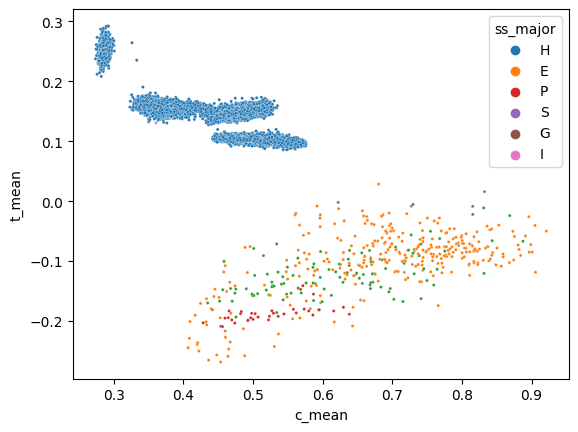

In [101]:
sns.scatterplot(data=df_1_2.loc[~ (df_1_2["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='ss_major', s=5)#df_1_2
#sns.scatterplot(data=all_canonical, x='c_mean', y='t_mean', hue='label', s=10)#df_1_2


In [ ]:
#sns.scatterplot(data=df_1_2.loc[~ (df_1_2["grp_frag_clusters"] == -1)], x='w_mean', y='t_mean', hue='ss_major', s=5)#df_1_2
sns.scatterplot(data=df_1_2, x='w_mean', y='t_mean', hue='ss_major', s=5)#df_1_2


In [ ]:
Pc_LIM = 0.4
# 4.3) Determinate which points belongs to the core of the clusters
print(f'  > selecting data points belonging to clusters core (Pc_lim = {Pc_LIM})...')
df_1_2['is_at_core'] = get_core_labels(df_1_2, Pc_LIM=Pc_LIM)
print(df_1_2[['membership_vec','is_at_core']])
core_df = df_1_2.loc[df_1_2['is_at_core']==True]

In [ ]:
sns.scatterplot(data=df_1_2, x="c_mean", y="t_mean", s=2, alpha=0.5,label="df_1_2", c="grey")
sns.scatterplot(data=core_df, x="c_mean", y="t_mean", s=2, alpha=0.5,label="core_df", c="blue")


In [ ]:
# final cluster
print('  :: ', len(core_df), 'total fragments selected' )
print(np.unique(core_df['grp_frag_clusters'], return_counts=True))
sns.scatterplot(data=core_df, x="c_mean", y="t_mean", hue="grp_frag_clusters", s=2, alpha=0.5, c="blue")

#grp_df_wgrtr.to_csv(save_dir+"/grp_df_wgrtr.csv")
#print('   > saving core dataframes at ', save_dir,'...')


In [ ]:
core_df.loc[core_df["grp_frag_clusters"] == 3][["pdbid", "c_mean", "t_mean", "ss"]]

## PP2 helix

# CANONICAL

In [82]:
cols_order = ['pdbid','chain','kind','res_start','res_final','size','seq','ss',
              'c_mean','c_std','c_std_s','label','cluster','cs_mean',
              'hn1_A_mean',      'hn1_A_median',         'hn1_A_std',
              'hn1_A_vals',       'hn1_en_mean',     'hn1_en_median',
              'hn1_en_std',       'hn1_en_vals',        'hn2_A_mean',
            'hn2_A_median',         'hn2_A_std',        'hn2_A_vals',
             'hn2_en_mean',     'hn2_en_median',        'hn2_en_std',
             'hn2_en_vals',        'ho1_A_mean',      'ho1_A_median',
               'ho1_A_std',        'ho1_A_vals',       'ho1_en_mean',
           'ho1_en_median',        'ho1_en_std',       'ho1_en_vals',
              'ho2_A_mean',         'ho2_A_std',        'ho2_A_vals',
             'ho2_en_mean',     'ho2_en_median',        'ho2_en_std',
             'ho2_en_vals',            't_mean',
                   't_std',           't_std_s',           'ts_mean',
                  'w_mean',             'w_std',           'wr_mean',
                  'wr_std',
       'grp_frag_clusters']

In [83]:
# load canonical dfs
can_dir = "/home/ubuntu/Projects/git_stuff/SSAxgeo/canonical/"
alpha_df=pck.load(open(f"{can_dir}alpha_can.p", "rb"))
alpha_df.drop([0,1], axis=1, inplace=True)
#alpha_df.rename(columns={0:"pdbid", 1:"chain"}, inplace=True)
alpha_df[cols_order].to_csv(f"{can_dir}alpha_can.csv", index=False)

pi_df=pck.load(open(f"{can_dir}pi_can.p", "rb"))
pi_df.drop([0,1], axis=1, inplace=True)
#pi_df.rename(columns={0:"pdbid", 1:"chain"}, inplace=True)
pi_df[cols_order].to_csv(f"{can_dir}pi_can.csv", index=False)

three_df=pck.load(open(f"{can_dir}three_can.p", "rb"))
three_df.drop([0,1], axis=1, inplace=True)
#three_df.rename(columns={0:"pdbid", 1:"chain"}, inplace=True)
three_df[cols_order].to_csv(f"{can_dir}three_can.csv", index=False)

pp2_df=pck.load(open(f"{can_dir}pp2_can.p", "rb"))
#pp2_df.rename(columns={0:"pdbid", 1:"chain"}, inplace=True)
pp2_df.drop([0,1], axis=1, inplace=True)
pp2_df["label"] = "pp2"
pp2_df[cols_order].to_csv(f"{can_dir}pp2_can.csv", index=False)

In [76]:
alpha_df.columns

Index([           'c_mean',             'c_std',           'c_std_s',
                   'chain',           'cluster',           'cs_mean',
              'hn1_A_mean',      'hn1_A_median',         'hn1_A_std',
              'hn1_A_vals',       'hn1_en_mean',     'hn1_en_median',
              'hn1_en_std',       'hn1_en_vals',        'hn2_A_mean',
            'hn2_A_median',         'hn2_A_std',        'hn2_A_vals',
             'hn2_en_mean',     'hn2_en_median',        'hn2_en_std',
             'hn2_en_vals',        'ho1_A_mean',      'ho1_A_median',
               'ho1_A_std',        'ho1_A_vals',       'ho1_en_mean',
           'ho1_en_median',        'ho1_en_std',       'ho1_en_vals',
              'ho2_A_mean',         'ho2_A_std',        'ho2_A_vals',
             'ho2_en_mean',     'ho2_en_median',        'ho2_en_std',
             'ho2_en_vals',              'kind',             'pdbid',
               'res_final',         'res_start',               'seq',
                    

In [84]:
all_canonical = pd.concat([alpha_df,pi_df,three_df,pp2_df], ignore_index=True)

#all_canonical[[0,1]]#.columns

<Axes: xlabel='c_mean', ylabel='t_mean'>

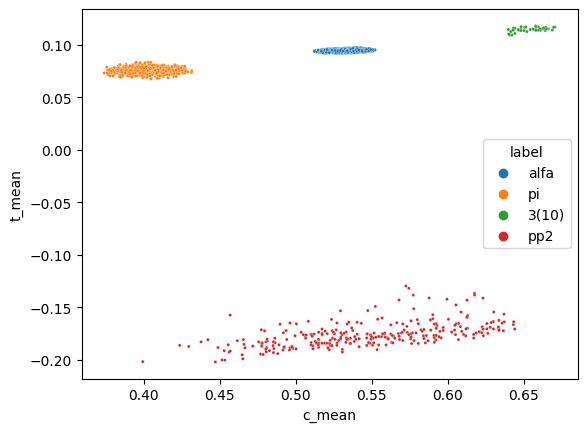

In [85]:
sns.scatterplot(data=all_canonical, x='c_mean', y='t_mean', hue='label', s=5)#df_1_2


<Axes: xlabel='w_mean', ylabel='t_mean'>

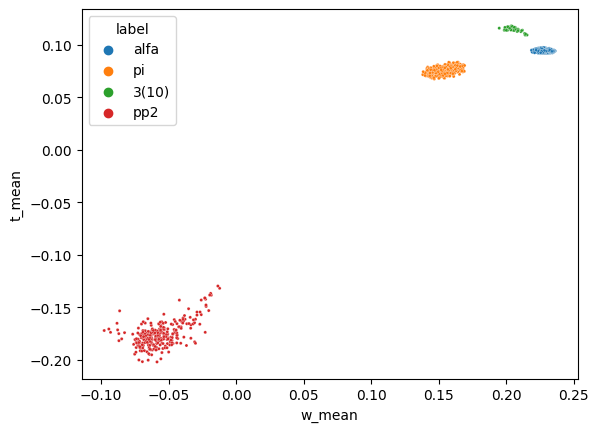

In [114]:
sns.scatterplot(data=all_canonical, x='w_mean', y='t_mean', hue='label', s=5)#df_1_2


In [100]:
three_df[cols_order].loc[three_df["size"]>4]#[["t_mean","ts_mean"]]

,pdbid,chain,kind,res_start,res_final,size,seq,ss,c_mean,c_std,...,ho2_en_vals,t_mean,t_std,t_std_s,ts_mean,w_mean,w_std,wr_mean,wr_std,grp_frag_clusters
3848,3zp7,C,round,59,64,6,"[A, K, A, V, R, E]","[G, G, G, G, G, G]",0.666132,0.105277,...,"[-0.2, -0.3, -0.3, -0.3, -0.5, -0.2]",0.115371,0.009422,0.009422,0.115371,0.205151,0.014445,0.205151,0.014445,1
6887,2yic,A,round,927,931,5,"[L, Q, L, L, A]","[G, G, G, G, G]",0.657785,0.099853,...,"[-0.3, -0.3, -0.5, -0.3, -0.2]",0.115051,0.012677,0.012677,0.115051,0.208543,0.013706,0.208543,0.013706,1
7652,2j7u,A,round,550,554,5,"[E, K, I, I, Q]","[G, G, G, G, G]",0.663870,0.029860,...,"[-0.3, -0.4, -0.2, -0.3, -0.3]",0.116448,0.014174,0.014174,0.116448,0.202230,0.014456,0.202230,0.014456,1
12767,2nw8,B,round,145,150,6,"[M, L, Q, V, F, A]","[G, G, G, G, G, T]",0.644334,0.104071,...,"[-0.3, -0.4, -0.3, -0.5, -0.5, -0.3]",0.115983,0.013390,0.013390,0.115983,0.194748,0.028178,0.194748,0.028178,1
53209,3wvq,D,round,23,29,7,"[A, V, Q, R, L, V, W]","[G, G, G, G, G, G, G]",0.656051,0.159542,...,"[-0.2, -0.2, -0.3, -0.3, -0.3, -0.3, -0.2]",0.114973,0.010547,0.010547,0.114973,0.199962,0.011242,0.199962,0.011242,1
55826,3hno,A,round,200,204,5,"[A, G, G, L, A]","[G, G, G, G, G]",0.664449,0.070020,...,"[-0.7, -0.5, -0.4, -0.3, -0.3]",0.116698,0.004186,0.004186,0.116698,0.206581,0.014468,0.206581,0.014468,1
58653,4ar9,A,round,420,424,5,"[E, Y, K, L, N]","[H, H, T, T, H]",0.643084,0.047119,...,"[-0.2, -0.3, -0.7, -0.3, -0.2]",0.114008,0.011633,0.011633,0.114008,0.211912,0.008617,0.211912,0.008617,1
163133,4rep,A,round,204,209,6,"[M, T, M, I, P, H]","[G, G, G, H, H, H]",0.648308,0.094669,...,"[-0.3, -0.3, -0.2, -0.3, 0.0, -0.3]",0.117418,0.008702,0.008702,0.117418,0.200982,0.012768,0.200982,0.012768,1


# COMPARE FLEXGEO TO MELODIA


In [134]:
flx_path = "/home/ubuntu/Projects/git_stuff/SSAxgeo/3zp7_C_flxgeo.csv"
mel_path = "/home/ubuntu/Projects/git_stuff/SSAxgeo/3zp7_C_xdata_df.csv"
dgo_path = "/home/ubuntu/Projects/git_stuff/SSAxgeo/3zp7_C.csv"

flx_cols = ["conf", "res", "curv", "tor", "arc","wri", "ca_x", "ca_y", "ca_z","res_name"]
flx_df = pd.read_csv(flx_path, names=flx_cols)

mel_df = pd.read_csv(mel_path)

dgo_cols = ["conf","res_name","atom", "res", "curv", "tor", "wri","arc"]
dgo_df = pd.read_csv(dgo_path, names=dgo_cols)

In [137]:
print(f"{len(dgo_df)}| {len(flx_df)} | {len(mel_df)}")

116| 116 | 116


In [143]:
(flx_df["curv"] - mel_df["curv"] ).values

array([-0.60388071, -0.01774571,  0.19404331,  0.03557889,  0.06514301,
        0.0744845 ,  0.0670065 ,  0.12110109,  0.10778454,  0.08817552,
        0.08851865,  0.11300037,  0.1283837 ,  0.10749968,  0.27888746,
        0.19576858,  0.29800662,  0.15751852,  0.11804859,  0.15204973,
        0.14023375,  0.13672139,  0.14190737,  0.16505212,  0.17023414,
        0.17009263,  0.14553225,  0.15400722,  0.16375405,  0.15847764,
        0.16660717,  0.14413956,  0.09948009,  0.14378682,  0.3145147 ,
        0.98441013,  0.46797327,  0.53246004,  0.39667222,  0.26160519,
        0.30144885,  0.38188745,  0.4841257 ,  0.11325011,  0.25821087,
        0.42151723,  0.42741157,  0.34057127,  0.25689525,  0.32608817,
        0.35314073,  0.31937555,  0.21567719,  0.31347716,  0.18563632,
        0.03388283,  0.38414077,  0.68232816,  0.4688861 ,  0.30351895,
        0.23616193,  0.23671219,  0.28094919,  0.48537076,  0.37156585,
        0.34425462,  0.29430403,  0.47080962,  0.36304376,  0.45

<Axes: ylabel='curv'>

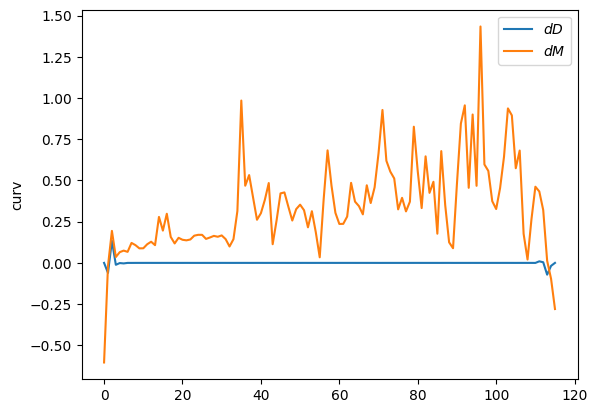

In [150]:
sns.lineplot((flx_df["curv"] - dgo_df["curv"]), label=r"$dD$")
sns.lineplot((flx_df["curv"] - mel_df["curv"]), label=r"$dM$")



<Axes: ylabel='tor'>

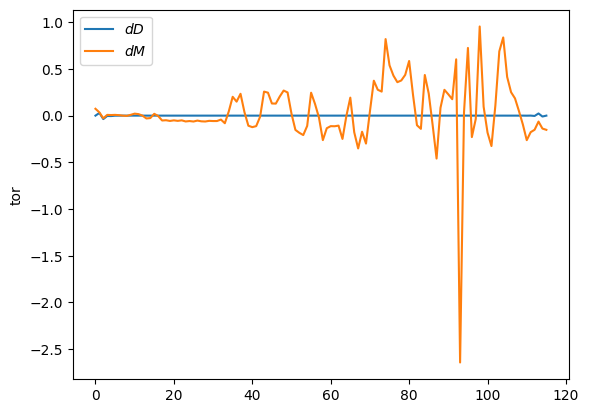

In [151]:
sns.lineplot((flx_df["tor"] - dgo_df["tor"]), label=r"$dD$")
sns.lineplot((flx_df["tor"] - mel_df["tor"]), label=r"$dM$")

<Axes: ylabel='wri'>

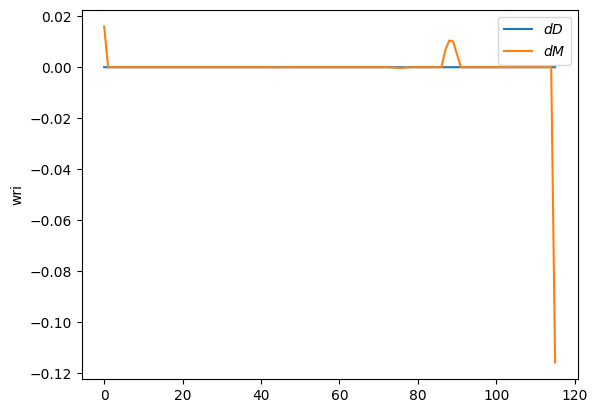

In [152]:
sns.lineplot((flx_df["wri"] - dgo_df["wri"]), label=r"$dD$")
sns.lineplot((flx_df["wri"] - mel_df["wri"]), label=r"$dM$")

In [ ]:
# TODO MIGRATE CODE TO DIFFGEO OR FLEXGEO